Processing: C:\Users\soham\OneDrive\Desktop\fdip sample photos\istockphoto-1445614323-612x612.jpg
Processing: C:\Users\soham\OneDrive\Desktop\fdip sample photos\Nikon-Z8-Official-Samples-00021 (1).jpg
Processing: C:\Users\soham\OneDrive\Desktop\fdip sample photos\pexels-robinstickel-70497.jpg

=== SUMMARY ===
istockphoto-1445614323-612x612.jpg  PSNR=35.04 dB   Ratio=5.95
Nikon-Z8-Official-Samples-00021 (1).jpg  PSNR=32.62 dB   Ratio=6.92
pexels-robinstickel-70497.jpg  PSNR=36.11 dB   Ratio=6.57

Average PSNR: 34.59 dB
Average Compression Ratio: 6.48


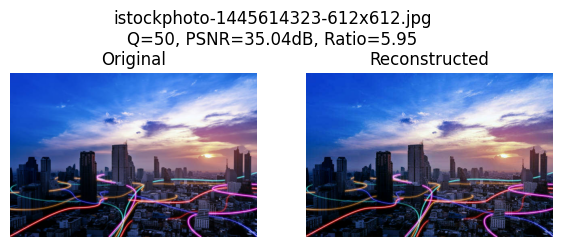

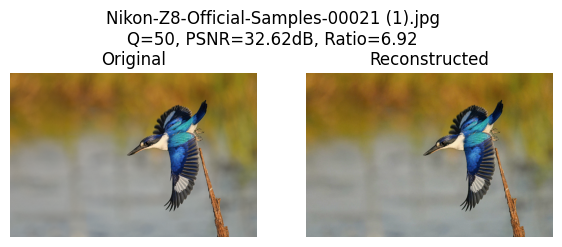

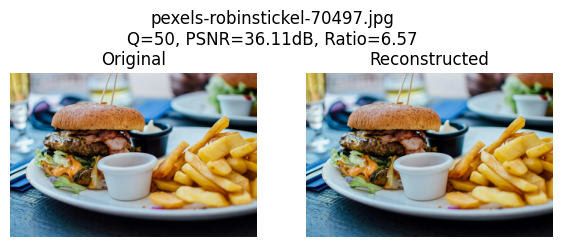

In [4]:
# Multiple image DCT + Huffman compression (simple & short)
# Works in Jupyter too
# pip install numpy pillow scipy matplotlib

import numpy as np, math, heapq, os
from PIL import Image
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# ----- utils -----
def dct2(b): return dct(dct(b.T, norm='ortho').T, norm='ortho')
def idct2(b): return idct(idct(b.T, norm='ortho').T, norm='ortho')

STD_Q = np.array([
 [16,11,10,16,24,40,51,61],
 [12,12,14,19,26,58,60,55],
 [14,13,16,24,40,57,69,56],
 [14,17,22,29,51,87,80,62],
 [18,22,37,56,68,109,103,77],
 [24,35,55,64,81,104,113,92],
 [49,64,78,87,103,121,120,101],
 [72,92,95,98,112,100,103,99]
], dtype=float)

def quant_matrix(q):
    q=max(1,min(100,int(q)))
    scale=(5000.0/q) if q<50 else (200-2*q)
    Q=np.floor((STD_Q*scale+50)/100); Q[Q==0]=1; return Q

class Node:
    def __init__(self,f,s,left=None,right=None): self.f=f; self.s=s; self.left=left; self.right=right
    def __lt__(self,o): return self.f<o.f
def build_code(symbols):
    freq={}
    for s in symbols: freq[s]=freq.get(s,0)+1
    heap=[Node(f,s) for s,f in freq.items()]; heapq.heapify(heap)
    if not heap: return {},''
    while len(heap)>1:
        a=heapq.heappop(heap); b=heapq.heappop(heap)
        heapq.heappush(heap, Node(a.f+b.f,None,a,b))
    root=heap[0]; codes={}
    def walk(n,p):
        if n.s is not None: codes[n.s]=p or '0'
        else: walk(n.left,p+'0'); walk(n.right,p+'1')
    walk(root,'')
    bitstr=''.join(codes[s] for s in symbols)
    return codes,bitstr
def huff_decode(bitstr,codes):
    inv={v:k for k,v in codes.items()}; cur=''; out=[]
    for b in bitstr:
        cur+=b
        if cur in inv: out.append(inv[cur]); cur=''
    return out

def mse(a,b): return np.mean((a.astype(np.float32)-b.astype(np.float32))**2)
def psnr(a,b): m=mse(a,b); return 9999.0 if m==0 else 20*math.log10(255.0/math.sqrt(m))

# ----- compression function -----
def compress_image(path, quality=50, show=False):
    img=Image.open(path).convert('RGB')
    arr=np.array(img).astype(np.float32)
    h,w=arr.shape[:2]
    Q=quant_matrix(quality)
    ycbcr=np.array(Image.fromarray(arr.astype(np.uint8),'RGB').convert('YCbCr')).astype(np.float32)
    bits=0; recons=[]
    for ch in range(3):
        c=ycbcr[:,:,ch]-128.0
        H=((h+7)//8)*8; W=((w+7)//8)*8
        pad=np.zeros((H,W)); pad[:h,:w]=c
        blocks=[]; 
        for i in range(0,H,8):
            for j in range(0,W,8):
                B=dct2(pad[i:i+8,j:j+8])
                QB=np.round(B/Q).astype(int)
                blocks.append(QB.flatten().tolist())
        symbols=[str(x) for b in blocks for x in b]
        codes,bitstr=build_code(symbols); bits+=len(bitstr)
        dec=[int(x) for x in huff_decode(bitstr,codes)]
        rec_blocks=[]; idx=0
        for _ in range(len(blocks)):
            arr64=np.array(dec[idx:idx+64]).reshape(8,8); idx+=64
            B=arr64*Q; rec_blocks.append(idct2(B)+128.0)
        channel=np.zeros((H,W)); k=0
        for i in range(0,H,8):
            for j in range(0,W,8):
                channel[i:i+8,j:j+8]=rec_blocks[k]; k+=1
        recons.append(channel[:h,:w])
    rec_ycbcr=np.stack(recons,axis=2).clip(0,255).astype(np.uint8)
    rec_rgb=Image.fromarray(rec_ycbcr,mode='YCbCr').convert('RGB')
    recon=np.array(rec_rgb)
    flat=arr.flatten().astype(np.uint8).tolist()
    codes2,bitstr2=build_code([str(x) for x in flat])
    lossless_bits=len(bitstr2)
    ratio=(h*w*3*8)/bits
    p=psnr(arr,recon)
    if show:
        plt.figure(figsize=(7,3))
        plt.suptitle(f"{os.path.basename(path)}\nQ={quality}, PSNR={p:.2f}dB, Ratio={ratio:.2f}")
        plt.subplot(1,2,1); plt.title("Original"); plt.axis('off'); plt.imshow(arr.astype(np.uint8))
        plt.subplot(1,2,2); plt.title("Reconstructed"); plt.axis('off'); plt.imshow(recon)
        plt.show()
    return {"name":os.path.basename(path),"psnr":p,"ratio":ratio,"lossy_bits":bits,"lossless_bits":lossless_bits}

# ----- run for all images in folder -----
FOLDER = r"C:\Users\soham\OneDrive\Desktop\fdip sample photos"  #  put your folder path here
QUALITY = 50  # compression quality (1-100)

files=[os.path.join(FOLDER,f) for f in os.listdir(FOLDER) if f.lower().endswith(('.jpg','.png','.jpeg'))]
if not files:
    print("No images found in folder.")
else:
    results=[]
    for f in files:
        print(f"Processing: {f}")
        res=compress_image(f, QUALITY, show=False)
        results.append(res)
    print("\n=== SUMMARY ===")
    for r in results:
        print(f"{r['name']:<25}  PSNR={r['psnr']:.2f} dB   Ratio={r['ratio']:.2f}")
    avg_psnr=np.mean([r['psnr'] for r in results])
    avg_ratio=np.mean([r['ratio'] for r in results])
    print(f"\nAverage PSNR: {avg_psnr:.2f} dB")
    print(f"Average Compression Ratio: {avg_ratio:.2f}")

    # show few samples
    for f in files[:3]:
        compress_image(f, QUALITY, show=True)
